<a href="https://colab.research.google.com/github/weso500/QMLIIOT/blob/main/TEPQAE2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 129.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.7 MB/s eta 0:00:00


In [2]:
pip install qiskit

In [3]:
pip install qiskit-machine-learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 10.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
  Attempting uninstall: qiskit
    Found existing installation: qiskit 2.2.2
    Uninstalling qiskit-2.2.2:
      Successfully uninstalled qiskit-2.2.2


In [6]:
# =============================
# =======  DATA SETUP  ========
# =============================

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# --- Load your data ---
train_df = pd.read_csv('/content/drive/MyDrive/QMLIIOT/TEP9Train_large.csv')
test_df  = pd.read_csv('/content/drive/MyDrive/QMLIIOT/TEP9Test_large.csv')

train_features = train_df.to_numpy()          # all normal
test_features  = test_df.to_numpy()           # mix of normal + anomalies
y_test = np.concatenate((np.zeros(500), np.ones(25)))  # 525 test targets

print(f"Train shape: {train_features.shape}")
print(f"Test shape:  {test_features.shape}")
print(f"Targets:     {y_test.shape}")

# --- Scale and convert to angles ---
scaler = StandardScaler()
X_normals_scaled = scaler.fit_transform(train_features)
X_test_scaled    = scaler.transform(test_features)

# map to quantum rotation angles
X_normals_angles = features_to_angles(X_normals_scaled)
X_test_angles    = features_to_angles(X_test_scaled)

# --- Split training normals into train/val for early stopping ---
X_train_angles, X_val_angles = train_test_split(
    X_normals_angles, test_size=0.15, random_state=seed, shuffle=True
)

print(f"Train angles: {X_train_angles.shape}, Val angles: {X_val_angles.shape}")

Train shape: (4500, 11)
Test shape:  (525, 11)
Targets:     (525,)
Train angles: (3825, 11), Val angles: (675, 11)


iter=  50  train=0.8553  val=0.8615  best_val=0.8615
iter= 100  train=0.8638  val=0.8615  best_val=0.8615
iter= 150  train=0.8551  val=0.8615  best_val=0.8615
iter= 200  train=0.8640  val=0.8615  best_val=0.8615
iter= 250  train=0.8721  val=0.8615  best_val=0.8615
iter= 300  train=0.8620  val=0.8615  best_val=0.8615
iter= 350  train=0.8534  val=0.8614  best_val=0.8614
iter= 400  train=0.8550  val=0.8614  best_val=0.8614
iter= 450  train=0.8615  val=0.8614  best_val=0.8614
iter= 500  train=0.8577  val=0.8614  best_val=0.8614
iter= 550  train=0.8502  val=0.8614  best_val=0.8614
iter= 600  train=0.8670  val=0.8614  best_val=0.8614
iter= 650  train=0.8585  val=0.8614  best_val=0.8614
iter= 700  train=0.8577  val=0.8614  best_val=0.8614
iter= 750  train=0.8649  val=0.8614  best_val=0.8614
iter= 800  train=0.8608  val=0.8614  best_val=0.8614


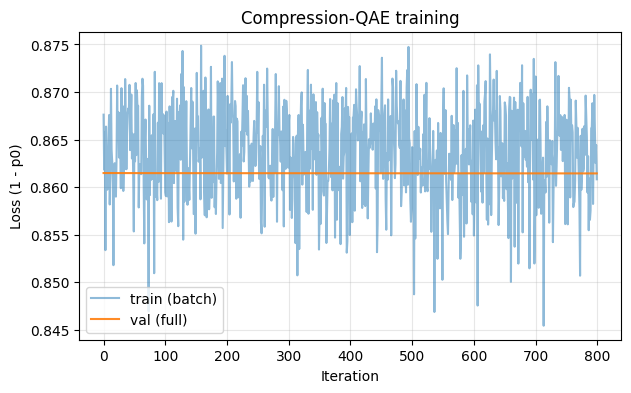

Compression-QAE AUC: 0.52512


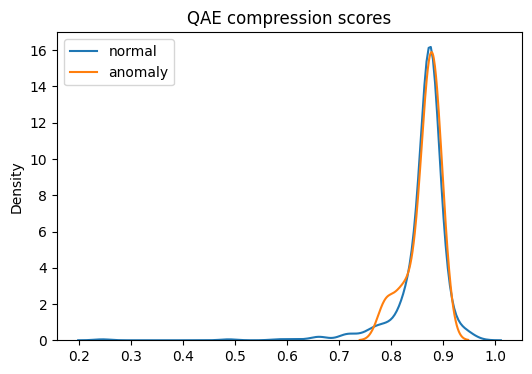

In [7]:
# Compression-style QAE (Statevector) with:
# - No rotations on trash
# - Latent configurable (default 7 of 11)
# - SPSA w/ validation split + early stopping
# - Loss logging & plots
# - p0-based anomaly scores

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import seaborn as sns

# -----------------------------
# Data placeholders (REPLACE!)
# -----------------------------
# X_normals_raw: (N_normals, 11) -> NORMALS ONLY for training/validation
# X_test_raw:    (N_test, 11)    -> mixed normals + anomalies
# y_test:        (N_test,)       -> 0 normal, 1 anomaly
#
# X_normals_raw = ...
# X_test_raw    = ...
# y_test        = ...

# -----------------------------
# Hyperparameters
# -----------------------------
n_input   = 11              # features
n_latent  = 8               # keep 7, compress 4 trash (indices: 7..10)
use_anc   = True            # use ancilla
n_qubits  = n_input + (1 if use_anc else 0)
anc_idx   = n_input if use_anc else None

reps      = 3               # ansatz depth
seed      = 42
rng       = np.random.RandomState(seed)

# SPSA
maxiter   = 800
batch_size= 96
a, c      = 0.15, 0.05
A         = 0.1 * maxiter
alpha, gamma = 0.602, 0.101
patience  = 75              # early stopping patience (iterations)

# -----------------------------
# Sets & indices
# -----------------------------
latent_idx = list(range(0, n_latent))
trash_idx  = list(range(n_latent, n_input))  # do NOT rotate these
all_rot_idx = latent_idx + ([anc_idx] if use_anc else [])
rot_per_layer = 2 * len(all_rot_idx)         # RY + RZ per rot qubit per layer
n_params = reps * rot_per_layer

# -----------------------------
# Feature -> angle mapping
# -----------------------------
def features_to_angles(X, clip=2.5):
    """
    Input X should be scaled (StandardScaler). We clip outliers then arctan-map
    to avoid saturating large rotations. Result approx in [-pi, pi] without extremes.
    """
    Z = np.clip(X, -clip, clip)
    return np.arctan(Z) * (2/np.pi) * np.pi

# -----------------------------
# Circuits
# -----------------------------
def prep_state_from_angles(angles):
    """
    Prepare RY(angles[i]) on data qubits 0..n_input-1. Ancilla (if any) left |0>.
    """
    qc = QuantumCircuit(n_qubits)
    for i in range(n_input):
        qc.ry(float(angles[i]), i)
    return qc

def build_encoder(params):
    """
    Trainable RY-RZ only on latent qubits (+ ancilla if enabled).
    Entangling ladder spans *all* qubits (latent + trash + ancilla).
    """
    qc = QuantumCircuit(n_qubits)
    idx = 0
    for _ in range(reps):
        # single-qubit rotations on allowed rot qubits
        for q in all_rot_idx:
            qc.ry(float(params[idx]), q); idx += 1
            qc.rz(float(params[idx]), q); idx += 1
        # entangling ladder across all qubits
        for q in range(n_qubits - 1):
            qc.cx(q, q+1)
    return qc

# -----------------------------
# Core: p0 (trash = all |0>) from statevector
# -----------------------------
def p0_from_statevector(sv):
    """
    Probability that *all trash qubits* are |0>. Ancilla can be anything.
    sv: complex array length 2^n_qubits (little-endian indexing).
    """
    probs = np.abs(sv)**2
    total = 0.0
    # iterate basis states; sum probs where every trash qubit bit=0
    for idx, p in enumerate(probs):
        ok = True
        for q in trash_idx:
            if (idx >> q) & 1:  # trash bit is 1 -> not ok
                ok = False
                break
        if ok:
            total += p
    return float(total)

# -----------------------------
# Loss on a batch (compression QAE): 1 - mean(p0)
# -----------------------------
def evaluate_loss_batch(params, angles_batch):
    enc = build_encoder(params)
    total = 0.0
    for ang in angles_batch:
        prep = prep_state_from_angles(ang)
        circ = prep.compose(enc)
        sv   = Statevector.from_instruction(circ).data
        p0   = p0_from_statevector(sv)
        total += (1.0 - p0)
    return total / len(angles_batch)

# -----------------------------
# SPSA with validation + early stopping
# -----------------------------
def spsa_train_with_val(X_train_angles, X_val_angles, init_params=None):
    if init_params is None:
        params = 0.001 * rng.randn(n_params)
    else:
        params = init_params.copy()

    train_hist, val_hist = [], []
    best_params = params.copy()
    best_val    = float('inf')
    stalled     = 0

    def draw_batch(X):
        idx = rng.choice(len(X), size=min(batch_size, len(X)), replace=False)
        return X[idx]

    for k in range(int(maxiter)):
        ak = a / ((k + 1 + A) ** alpha)
        ck = c / ((k + 1) ** gamma)
        delta = rng.choice([-1.0, 1.0], size=params.shape)

        p_plus  = params + ck * delta
        p_minus = params - ck * delta

        batch = draw_batch(X_train_angles)
        y_plus  = evaluate_loss_batch(p_plus,  batch)
        y_minus = evaluate_loss_batch(p_minus, batch)
        ghat = (y_plus - y_minus) / (2.0 * ck) * delta
        params = params - ak * ghat

        # monitor
        train_loss = evaluate_loss_batch(params, draw_batch(X_train_angles))
        val_loss   = evaluate_loss_batch(params, X_val_angles)
        train_hist.append(train_loss)
        val_hist.append(val_loss)

        # early stopping
        if val_loss + 1e-9 < best_val:
            best_val    = val_loss
            best_params = params.copy()
            stalled     = 0
        else:
            stalled += 1
            if stalled > patience:
                print(f"[Early stop] iter={k}, best_val={best_val:.6f}")
                break

        if (k+1) % 50 == 0:
            print(f"iter={k+1:4d}  train={train_loss:.4f}  val={val_loss:.4f}  best_val={best_val:.4f}")

    return best_params, np.array(train_hist), np.array(val_hist)

# -----------------------------
# Scoring: anomaly score = 1 - p0
# -----------------------------
def qae_compression_scores(params, X_angles):
    enc = build_encoder(params)
    out = []
    for ang in X_angles:
        prep = prep_state_from_angles(ang)
        sv   = Statevector.from_instruction(prep.compose(enc)).data
        p0   = p0_from_statevector(sv)
        out.append(1.0 - p0)
    return np.array(out)

# -----------------------------
# Optional: rank-ensemble helper
# -----------------------------
def rank_ensemble(score_list):
    import scipy.stats as st
    ranks = np.vstack([st.rankdata(s) for s in score_list])
    return ranks.mean(axis=0)

# =============================
# ========  RUN PIPE  =========
# =============================
# 1) Scale -> angles
# scaler = StandardScaler()
# X_normals_scaled = scaler.fit_transform(X_normals_raw)
# X_test_scaled    = scaler.transform(X_test_raw)



# 3) Train (SPSA + early stopping)
best_params, train_hist, val_hist = spsa_train_with_val(X_train_angles,X_val_angles)

# 4) Plots: loss curves
plt.figure(figsize=(7,4))
plt.plot(train_hist, alpha=0.5, label='train (batch)')
plt.plot(val_hist,   alpha=0.9, label='val (full)')
plt.xlabel("Iteration"); plt.ylabel("Loss (1 - p0)")
plt.title("Compression-QAE training")
plt.legend(); plt.grid(alpha=0.3); plt.show()

# 5) Score test & AUC
scores = qae_compression_scores(best_params, X_test_angles)  # higher -> more anomalous
auc = roc_auc_score(y_test, scores)
print("Compression-QAE AUC:", auc)

# 6) Distributions
plt.figure(figsize=(6,4))
sns.kdeplot(scores[y_test==0], label='normal')
sns.kdeplot(scores[y_test==1], label='anomaly')
plt.title("QAE compression scores"); plt.legend(); plt.show()